## set up problem

In [1]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import xarray as xr

from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
# from pylops.optimization.solver  import cgls
from time import time

In [2]:
#set up constants
jtdata = 2 # shift to apply to the Mck pup
jt = 0 # shift to apply to R to allow alignment with Rest (obsolete)
ivs = 75 # virtual source to use for visualization

niter = 20 # MDD iterations

In [4]:
#load data
ds_mko = xr.open_dataset('../data/ds2/S_mko.nc')
# print("S-MKO REDATUMED WAVEFIELDS: {}".format(ds_mko.keys()))

# FD Local reflection response @ z=4400m, f_max -> 40Hz - axes, attrs included
ds_R = xr.open_dataset('../data/ds2/R_FD_40Hz_z4400.nc')
# print("R FINITE DIFFERENCES 60Hz : {}".format(ds_R.keys()))

In [5]:
# Receivers
r = ds_mko.coords['x_vs'].values
nr = r.size
dr = r[1]-r[0]

# Sources
s = ds_mko.coords['x_r'].values
ns = s.size
ds = s[1]-s[0]

# Time
t = ds_mko.coords['t'].values
nt = t.size
dt = t[1]-t[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

In [6]:
# Data (rescale to get values around 1)
pdown = ds_mko['g_plus'].values * 2000
pup = ds_mko['g_minus'].values * 2000

# pup.max(), pdown.max()

In [7]:
# Pad data with zero at the end (to avoid wrap around)
npad = 5
pdown = np.pad(pdown, ((0, npad), (0, 0), (0, 0)))

pup = np.pad(pup, ((0, npad+jtdata), (0, 0), (0, 0))) 
pup = pup[jtdata:]

Rorig = ds_R['R'].values
Rorig = np.pad(Rorig, ((0, npad), (0, 0), (0, 0)))

ntpad = pdown.shape[0]
tpad = np.arange(ntpad) * dt


In [8]:
# As R is currently q->vz, transform it into q->q
tracelim = (1e7, -1e7)

rho_sep = 2000
vel_sep = 2766.85
nfftf = ntpad
nfftk = nr
PtoVop = PressureToVelocity(ntpad, nr, dt, dr,
                            rho_sep, vel_sep,
                            nffts=(nfftk, nfftf),
                            critical=100., ntaper=11,
                            topressure=True)           

R = np.hstack([PtoVop * Rorig[:, ir].T.ravel() for ir in range(nr)])
R = np.real(R.reshape(nr, nr, ntpad)).transpose(2, 0, 1)
R = (R + R.transpose(0, 2, 1)) / 2 # enforce reciprocity


In [9]:
# Convert to frequency and define fmax
nfmax = 400
nfft = ntpad
FFTop = FFT2D(dims=[nr, ntpad], nffts=[nr, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[:, ns//2].T.flatten()).reshape(nr, nfft)
PDOWN = (FFTop*pdown[:, ns//2].T.flatten()).reshape(nr, nfft)

# Filter out high freqs from true response
RTRUE = np.concatenate([(FFTop * R[:, ir].T.ravel()).reshape(1, nr, nfft) for ir in range(nr)], axis=0)
RFILT = RTRUE.copy()
RFILT[:, :, nfmax:-nfmax] = 0
Rfilt = np.concatenate([np.real((FFTop.H * RFILT[ir].ravel()).reshape(1, nr, ntpad)) for ir in range(nr)], axis=0).transpose(2, 0, 1)


In [10]:
# Convert downgoing data to velocity
rho_sep = 2000
vel_sep = 2766.85
nfftf = ntpad
nfftk = nr
PtoVop = PressureToVelocity(ntpad, nr, dt, dr,
                            rho_sep, vel_sep,
                            nffts=(nfftk, nfftf),
                            critical=100., ntaper=11,
                            topressure=False)           

vzdown = np.hstack([PtoVop * pdown[:, isrc].T.ravel() for isrc in range(ns)])
vzdown = np.real(vzdown.reshape(ns, nr, ntpad)).transpose(2, 0, 1)
vzdown *= 1e7


In [11]:
#ops
def ops(nt, nv, ns, nr):
    from pylops import Identity
    from pylops.signalprocessing import FFT

    nfft = int(np.ceil((nt + 1) / 2))
    Iop = Identity(N=nfmax * nr * nv, M=nfft * nr * nv, inplace=True, dtype='float64')
    I1op = Identity(N=nfmax * ns * nv, M=nfft * ns * nv, inplace=True, dtype='float64')
    I1opH = I1op.H

    Fop = FFT(dims=(nt, nr, nv), dir=0, real=True, ifftshift_before=twosided, engine = 'numpy')
    F1op = FFT(dims=(nt, ns, nv),dir=0,real=True, ifftshift_before=False, engine = 'numpy')
    F1opH = F1op.H
    Iop_com = Identity(N=nfmax * nr * nv, M=nfft * nr * nv, inplace=True, dtype=complex)
    I1op_com = Identity(N=nfmax * ns * nv, M=nfft * ns * nv, inplace=True, dtype=complex)
    I1opH_com = I1op_com.H
    return Iop_com, Fop, I1opH_com, F1opH
# Fredholm
import numpy as np

from pylops import LinearOperator
from pylops.utils.backend import get_array_module
class Fredholm1(LinearOperator):
    def __init__(self, G, nz=1, saveGt=True, usematmul=True, dtype="float64"):
        self.nz = nz
        self.nsl, self.nx, self.ny = G.shape
        self.G = G
        if saveGt:
            self.GT = G.transpose((0, 2, 1)).conj()
        self.usematmul = usematmul
        self.shape = (self.nsl * self.nx * self.nz, self.nsl * self.ny * self.nz)
        self.dtype = np.dtype(dtype)
        self.explicit = False
    def _matvec(self, x):
        ncp = get_array_module(x)
#         x = ncp.squeeze(x.reshape(self.nsl, self.ny, self.nz))
        x = x.reshape(self.nsl, self.ny, self.nz)
        if self.usematmul:
            if self.nz == 1:
                x = x[..., ncp.newaxis]
            y = ncp.matmul(self.G, x)
        else:
#             y = ncp.squeeze(ncp.zeros((self.nsl, self.nx, self.nz), dtype=self.dtype))
            y = ncp.zeros((self.nsl, self.nx, self.nz), dtype=self.dtype)
            for isl in range(self.nsl):
                y[isl] = ncp.dot(self.G[isl], x[isl])
        return y.ravel()
    def _rmatvec(self, x):
        ncp = get_array_module(x)
#         x = ncp.squeeze(x.reshape(self.nsl, self.nx, self.nz))
        x = x.reshape(self.nsl, self.nx, self.nz)
#         print (f'rhs.shape: {x.shape}')
        if self.usematmul:
            if self.nz == 1:
                x = x[..., ncp.newaxis]
            if hasattr(self, "GT"):
                y = ncp.matmul(self.GT, x)
            else:
                # y = ncp.matmul(self.G.transpose((0, 2, 1)).conj(), x)
                y = (
                    ncp.matmul(x.transpose(0, 2, 1).conj(), self.G)
                    .transpose(0, 2, 1)
                    .conj()
                )
        else:
#             y = ncp.squeeze(ncp.zeros((self.nsl, self.ny, self.nz), dtype=self.dtype))
            y = ncp.zeros((self.nsl, self.ny, self.nz), dtype=self.dtype)
#             print (f'ans.shape: {y.shape}')
            if hasattr(self, "GT"):
                if 0: #self.nsl == 1:
                    y = ncp.dot(self.GT[0], x)
                else:
                    for isl in range(self.nsl):
                        y[isl] = ncp.dot(self.GT[isl], x[isl])
            else:
                for isl in range(self.nsl):
                    # y[isl] = ncp.dot(self.G[isl].conj().T, x[isl])
                    y[isl] = ncp.dot(x[isl].T.conj(), self.G[isl]).T.conj()
        return y.ravel()
# Frop = Fredholm1(dr * dt * np.sqrt(nt) * Gfft, nv, saveGt=saveGt, dtype=complex, usematmul=False)

In [12]:
twosided=False
IopXf, FopXf, IopBHf, FopBHf = ops(ntpad, nr, ns, nr)
IopX, FopX, IopBH, FopBH = ops(ntpad, 1, ns, nr)

In [13]:
# Modelling operator
iter_lim = 20
PDOWN = np.fft.rfft(vzdown, ntpad, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=ntpad, nv=nr, dt=dt, dr=dr, twosided=False, transpose=False)

# Adjoint
Radj = MDCop.H * pup.ravel()
Radj = np.real(Radj).reshape(ntpad, nr, nr)

In [14]:
nv = nr
rhs_fr = IopBHf.H.matvec(FopBHf.H.matvec(pup.ravel()))
rhs_fr = rhs_fr.reshape(nfmax, ns, nv)

In [15]:
#decompose w and rhs
rank = 50

BLS_mat = np.zeros((ns*nfmax, rank),dtype=complex)
BR_mat = np.zeros((rank*nfmax, nv),dtype=complex)
BL_mat = np.zeros((ns*nfmax, rank),dtype=complex)
BRS_mat = np.zeros((rank*nfmax, nv),dtype=complex)
BLS_ten = np.zeros((nfmax, ns, rank),dtype = complex)
BR_ten = np.zeros((nfmax, rank, nv),dtype = complex)
BL_ten = np.zeros((nfmax, ns, rank),dtype = complex)
BRS_ten = np.zeros((nfmax, rank, nv),dtype = complex)
BS = np.zeros(rank*nfmax, dtype = complex)
for ifr in range(nfmax):
    u,s,v = np.linalg.svd(rhs_fr[ifr,:,:])
    BLS_mat[ns*ifr:ns*(ifr+1),:] = u[:,:rank] @ np.diag(s[:rank])
    BR_mat[rank*ifr:rank*(ifr+1),:] = v[:rank,:] 
    BL_mat[ns*ifr:ns*(ifr+1),:] = u[:,:rank]
    BRS_mat[rank*ifr:rank*(ifr+1),:] = np.diag(s[:rank]) @ v[:rank,:] 
#     print (BLS_ten[ifr,:,:].shape, u[:,:rank].shape, np.diag(s[:rank].shape))
    BLS_ten[ifr,:,:] = u[:,:rank] @ np.diag(s[:rank])
    BR_ten[ifr,:,:] = v[:rank, :]
    BL_ten[ifr,:,:] = u[:,:rank]
    BRS_ten[ifr,:,:] =  np.diag(s[:rank]) @ v[:rank, :]
    BS[ifr*rank:(ifr+1)*rank] = s[:rank]

## Solve in frequency domain

### full

In [16]:
Frop_nv = Fredholm1(dr * dt * np.sqrt(nt) * PDOWN, nv, saveGt=1, dtype=complex, usematmul=False) 

#### non-sym

In [17]:
t0 = time()
x_full_ns_f = lsqr(Frop_nv, rhs_fr.ravel(), damp=1e-10, iter_lim=20, show=1)[0]
t_full_nsym = time() - t0
print(f'Time: {t_full_nsym}s')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 12140400 rows and 9120400 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.279e+01  3.279e+01    1.0e+00  2.3e+01
     1 -4.33380e-24   2.426e+01  2.426e+01    7.4e-01  2.8e-01   1.1e+03  1.0e+00
     2 -1.09084e-23   2.287e+01  2.287e+01    7.0e-01  1.2e-01   1.5e+03  2.1e+00
     3 -2.15854e-23   2.229e+01  2.229e+01    6.8e-01  7.7e-02   1.8e+03  3.6e+00
     4 -3.74965e-23   2.192e+01  2.192e+01    6.7e-01  5.8e-02   2.1e+03  5.4e+00
     5 -5.93920e-23   2.164e+01  2.164e+01    6.6e-01  4.7e-02   2.3e+03  7.5e+00
     6 -8.62894e-23   2.141e+01  2.141e+01    6.5e-01  3.9e-02   2.5e+03  9.9e+00
     7 -1.19044e-22   2.122e+01  2.122e+01    6.5e-01  3.4e-02   2.7e+03  1.2e+01
     8 -1.57919e-22   2.105

In [18]:
x_full_ns_t = ((FopXf.H @ (IopXf.H @ x_full_ns_f.ravel())).real).reshape(ntpad, nr, nv)

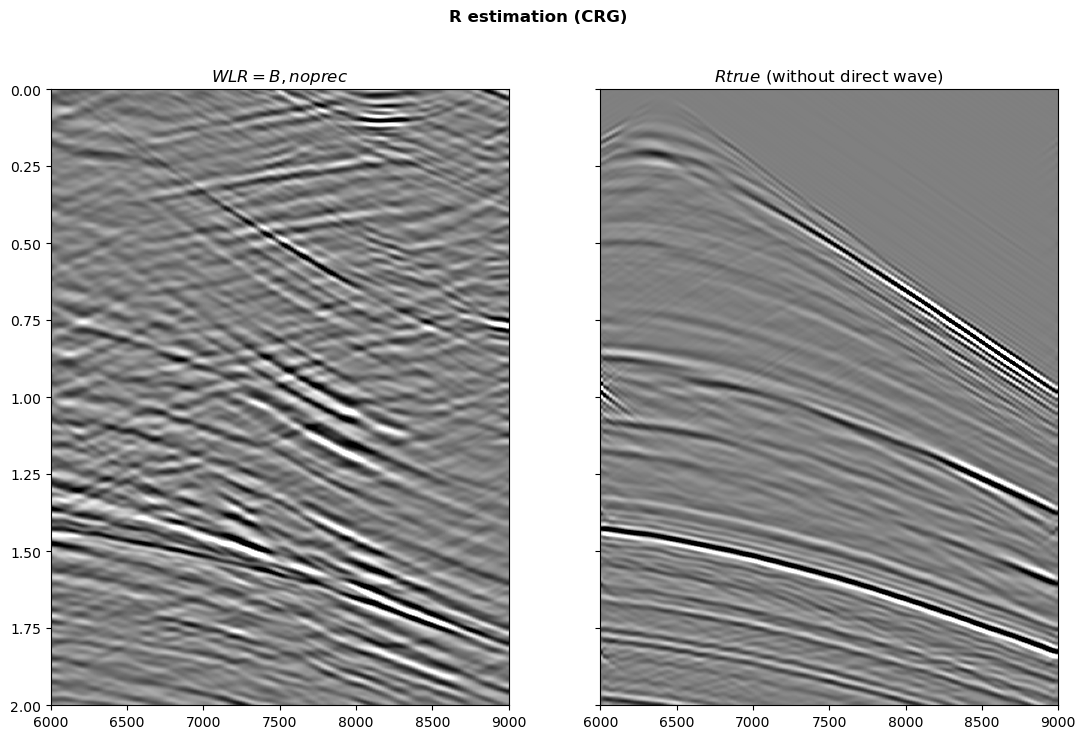

In [19]:
#plot
clip = 0.4
ivs = 20
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CRG)', fontweight='bold')

axs[0].imshow(x_full_ns_t[:nt, ivs], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$WLR=B, no prec$')
axs[0].axis('tight')

axs[1].imshow(Rfilt[:nt, :, ivs], cmap='gray',
              vmin=-clip*np.abs(Rfilt[:,  nr//2]).max(), vmax=clip*np.abs(Rfilt[:,  nr//2]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$Rtrue$ (without direct wave)')
axs[1].axis('tight')
axs[1].set_ylim(2., 0);

#### sym

In [20]:
Recop =  0.5 * (Identity(nfmax * nr * nr) + \
                Transpose((nfmax, nr, nr), (0, 2, 1)))

In [21]:
Frop_nv_pr = Frop_nv * Recop

In [22]:
t0 = time()
x_full_s_f = lsqr(Frop_nv_pr, rhs_fr.ravel(), damp=1e-10, iter_lim=20, show=1)[0]
t_full_sym = time() - t0
print(f'Time: {t_full_sym}s')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 12140400 rows and 9120400 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.279e+01  3.279e+01    1.0e+00  2.3e+01
     1 -4.42563e-24   2.437e+01  2.437e+01    7.4e-01  2.5e-01   1.1e+03  1.0e+00
     2 -1.09501e-23   2.328e+01  2.328e+01    7.1e-01  9.5e-02   1.5e+03  2.1e+00
     3 -2.00564e-23   2.296e+01  2.296e+01    7.0e-01  5.0e-02   1.8e+03  3.4e+00
     4 -3.19044e-23   2.283e+01  2.283e+01    7.0e-01  3.1e-02   2.1e+03  4.9e+00
     5 -4.65961e-23   2.276e+01  2.276e+01    6.9e-01  2.1e-02   2.3e+03  6.6e+00
     6 -6.36968e-23   2.272e+01  2.272e+01    6.9e-01  1.5e-02   2.5e+03  8.4e+00
     7 -8.36542e-23   2.269e+01  2.269e+01    6.9e-01  1.1e-02   2.7e+03  1.0e+01
     8 -1.06561e-22   2.267

In [23]:
x_full_s_t = ((FopXf.H @ (IopXf.H @ x_full_s_f.ravel())).real).reshape(ntpad, nr, nv)

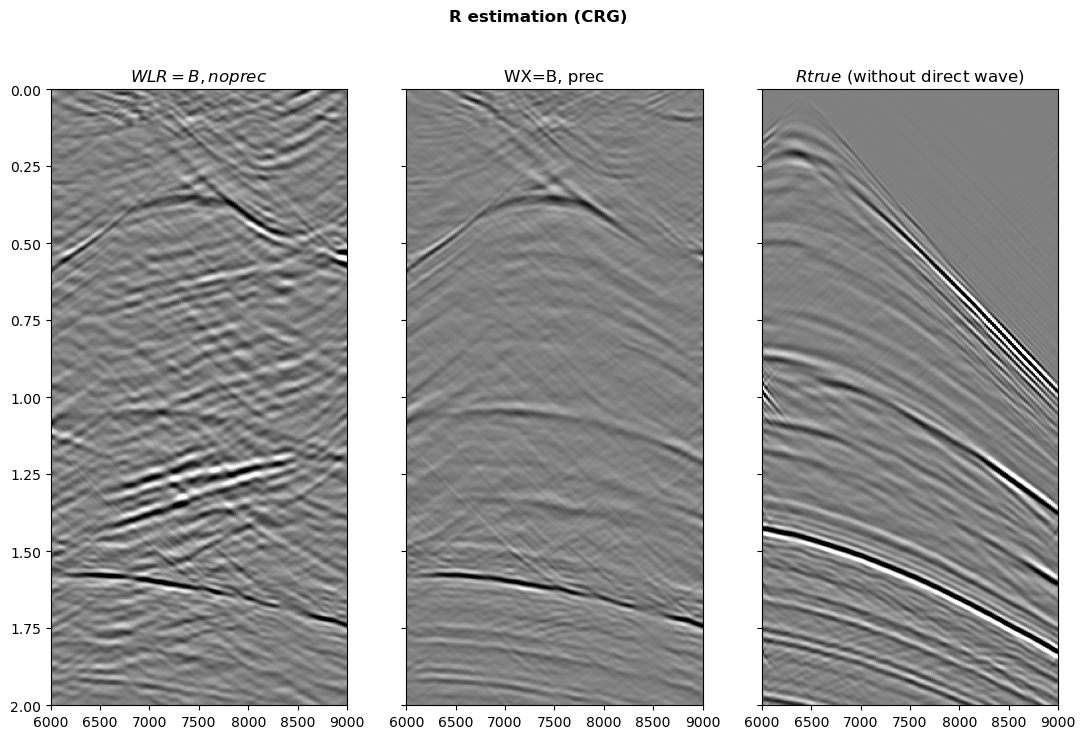

In [24]:
#plot

clip = 0.4
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CRG)', fontweight='bold')

axs[0].imshow(x_full_ns_t[:nt, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$WLR=B, no prec$')
axs[0].axis('tight')

axs[1].imshow(x_full_s_t[:nt, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'WX=B, prec')
axs[1].axis('tight')

axs[2].imshow(Rfilt[:nt, :, ivs], cmap='gray',
              vmin=-clip*np.abs(Rfilt[:,  nr//2]).max(), vmax=clip*np.abs(Rfilt[:,  nr//2]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[2].set_title(r'$Rtrue$ (without direct wave)')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

### LR

In [25]:
# rank = 50
Frop_r = Fredholm1(dr * dt * np.sqrt(nt) * PDOWN, rank, saveGt=1, dtype=complex, usematmul=False)

In [26]:
# #decompose rhs
# BLS_mat = np.zeros((ns*nfmax, rank),dtype=complex)
# BR_mat = np.zeros((rank*nfmax, nv),dtype=complex)
# BL_mat = np.zeros((ns*nfmax, rank),dtype=complex)
# BRS_mat = np.zeros((rank*nfmax, nv),dtype=complex)
# BLS_ten = np.zeros((nfmax, ns, rank),dtype = complex)
# BR_ten = np.zeros((nfmax, rank, nv),dtype = complex)
# BL_ten = np.zeros((nfmax, ns, rank),dtype = complex)
# BRS_ten = np.zeros((nfmax, rank, nv),dtype = complex)
# BS = np.zeros(rank*nfmax, dtype = complex)
# for ifr in range(nfmax):
#     u,s,v = np.linalg.svd(rhs_fr[ifr,:,:])
#     BLS_mat[ns*ifr:ns*(ifr+1),:] = u[:,:rank] @ np.diag(s[:rank])
#     BR_mat[rank*ifr:rank*(ifr+1),:] = v[:rank,:] 
#     BL_mat[ns*ifr:ns*(ifr+1),:] = u[:,:rank]
#     BRS_mat[rank*ifr:rank*(ifr+1),:] = np.diag(s[:rank]) @ v[:rank,:] 
# #     print (BLS_ten[ifr,:,:].shape, u[:,:rank].shape, np.diag(s[:rank].shape))
#     BLS_ten[ifr,:,:] = u[:,:rank] @ np.diag(s[:rank])
#     BR_ten[ifr,:,:] = v[:rank, :]
#     BL_ten[ifr,:,:] = u[:,:rank]
#     BRS_ten[ifr,:,:] =  np.diag(s[:rank]) @ v[:rank, :]
#     BS[ifr*rank:(ifr+1)*rank] = s[:rank]

In [27]:
#solve WRS*L = Bf
t0 = time()
L_tmp = lsqr(Frop_r, BLS_ten.ravel(), damp=1e-10, iter_lim=iter_lim, show=1)[0]
L_tmp = L_tmp.reshape(nfmax, nr, rank)
x_lr_f = np.zeros((nfmax, nr, nv),dtype = complex)
for ifr in range(nfmax):
    x_lr_f[ifr,:,:] = L_tmp[ifr,:,:] @ BR_ten[ifr,:,:]
x_lr_t = ((FopXf.H @ (IopXf.H @ x_lr_f.ravel())).real).reshape(ntpad, nr, nv)
t_lr = time() - t0
print (f'Time: {t_lr} sec')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 4020000 rows and 3020000 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.279e+01  3.279e+01    1.0e+00  2.3e+01
     1 -8.73304e-23   2.426e+01  2.426e+01    7.4e-01  2.8e-01   1.1e+03  1.0e+00
     2 -2.19808e-22   2.286e+01  2.286e+01    7.0e-01  1.2e-01   1.5e+03  2.1e+00
     3 -4.34941e-22   2.228e+01  2.228e+01    6.8e-01  7.7e-02   1.8e+03  3.6e+00
     4 -7.55541e-22   2.191e+01  2.191e+01    6.7e-01  5.8e-02   2.1e+03  5.4e+00
     5 -1.19675e-21   2.163e+01  2.163e+01    6.6e-01  4.7e-02   2.3e+03  7.5e+00
     6 -1.73875e-21   2.140e+01  2.140e+01    6.5e-01  3.9e-02   2.5e+03  9.9e+00
     7 -2.39880e-21   2.121e+01  2.121e+01    6.5e-01  3.4e-02   2.7e+03  1.2e+01
     8 -3.18220e-21   2.105e

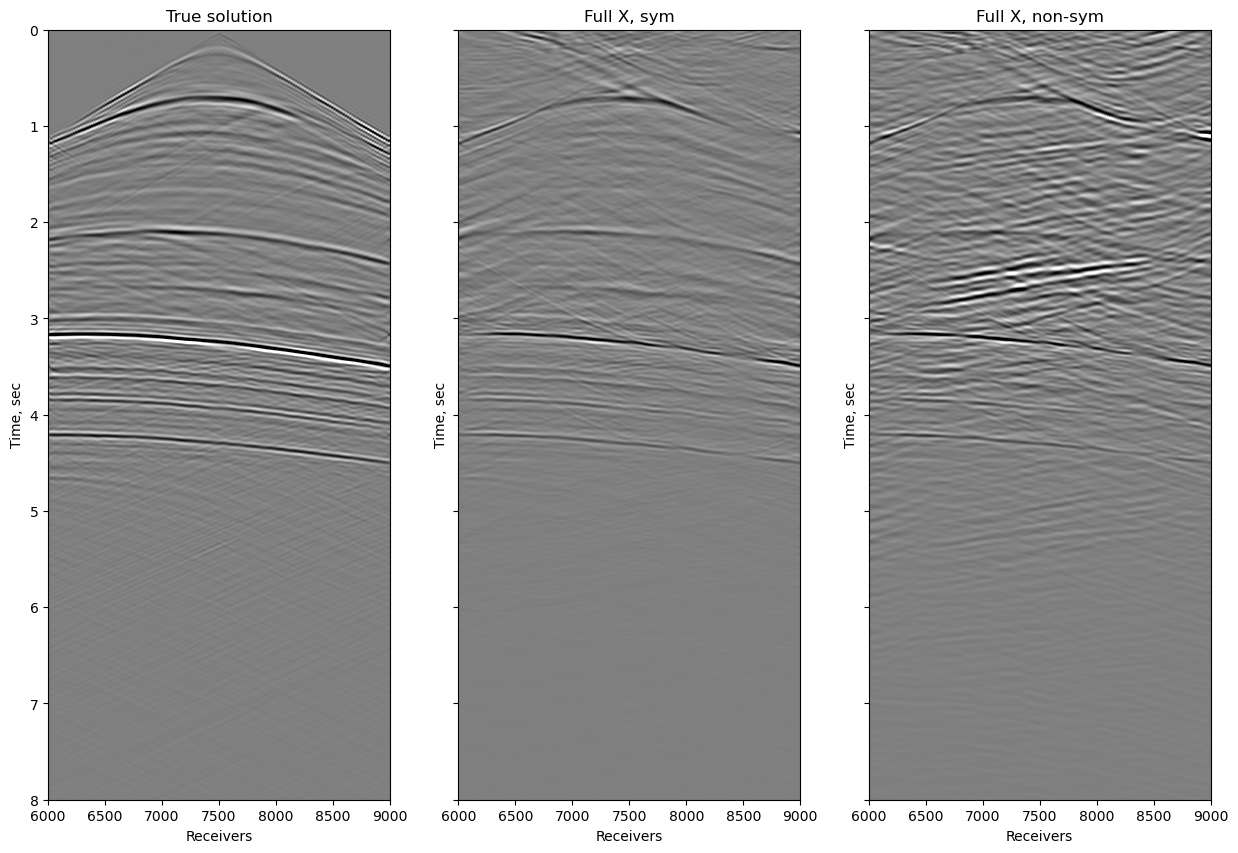

In [28]:
#plot

clip = 0.4
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 10))
# fig.suptitle('R estimation (CRG)', fontweight='bold')

axs[2].imshow(x_full_ns_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[2].set_title(f'Full X, non-sym')
axs[2].axis('tight')
axs[2].set_xlabel('Receivers', fontsize=10)
axs[2].set_ylabel('Time, sec', fontsize=10)

axs[1].imshow(x_full_s_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title('Full X, sym')
axs[1].axis('tight')
axs[1].set_xlabel('Receivers', fontsize=10)
axs[1].set_ylabel('Time, sec', fontsize=10)

axs[0].imshow(Rfilt[:nt//2, :, nr//2], cmap='gray',
              vmin=-clip*np.abs(Rfilt[:,  nr//2]).max(), vmax=clip*np.abs(Rfilt[:,  nr//2]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title("True solution")
axs[0].axis('tight')
axs[0].set_xlabel('Receivers', fontsize=10)
axs[0].set_ylabel('Time, sec', fontsize=10)
fig.savefig(f'../figs/ds2_lr')

### VSV

#### non-sym

In [29]:
W_core = dr * dt * np.sqrt(nt) * PDOWN
UWV_core =  np.zeros((nfmax, rank, rank), dtype = complex)
for ifr in range(nfmax):
    UWV_core[ifr,:,:] = BL_ten[ifr,:,:].conj().T @ W_core[ifr,:,:] @ BR_ten[ifr,:,:].T
UWV_sm = Fredholm1(UWV_core, rank, saveGt=1, dtype=complex, usematmul=False)

In [30]:
sig_rhs_ten = np.zeros((nfmax,rank,rank),dtype=complex)
for ifr in range(nfmax):
    sig_rhs_ten[ifr, : ,:] = np.diag(BS[ifr*rank:(ifr+1)*rank])

In [31]:
t0 = time()
x_sig_ns_f = lsqr(UWV_sm, sig_rhs_ten.ravel(), damp=1e-10, iter_lim=iter_lim, show=1)[0]
t_vsv_sm = time() - t0
print (f'Time: {t_vsv_sm} sec')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1000000 rows and 1000000 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.279e+01  3.279e+01    1.0e+00  2.3e+01
     1  2.98741e-22   2.354e+01  2.354e+01    7.2e-01  3.2e-01   1.1e+03  1.0e+00
     2  7.95480e-22   2.162e+01  2.162e+01    6.6e-01  1.6e-01   1.5e+03  2.2e+00
     3  1.57881e-21   2.072e+01  2.072e+01    6.3e-01  1.0e-01   1.7e+03  3.7e+00
     4  2.69455e-21   2.015e+01  2.015e+01    6.1e-01  7.6e-02   2.0e+03  5.5e+00
     5  4.20835e-21   1.971e+01  1.971e+01    6.0e-01  6.1e-02   2.2e+03  7.6e+00
     6  6.13099e-21   1.935e+01  1.935e+01    5.9e-01  5.2e-02   2.4e+03  9.9e+00
     7  8.47420e-21   1.905e+01  1.905e+01    5.8e-01  4.6e-02   2.6e+03  1.3e+01
     8  1.11717e-20   1.878e

In [32]:
x_sig_ns_f = x_sig_ns_f.reshape(nfmax, rank, rank)
x_vsv_ns_f = np.zeros((nfmax, nr, nv), dtype=complex)
for ifr in range(nfmax):
    x_vsv_ns_f[ifr,:,:] = BR_ten[ifr,:,:].T @ (x_sig_ns_f[ifr,:,:]) @ BR_ten[ifr,:,:]
x_vsv_ns_t = ((FopXf.H @ (IopXf.H @  x_vsv_ns_f.ravel())).real).reshape(ntpad, nr, nv)

(6000.0, 9000.0, 8.0, 0.0)

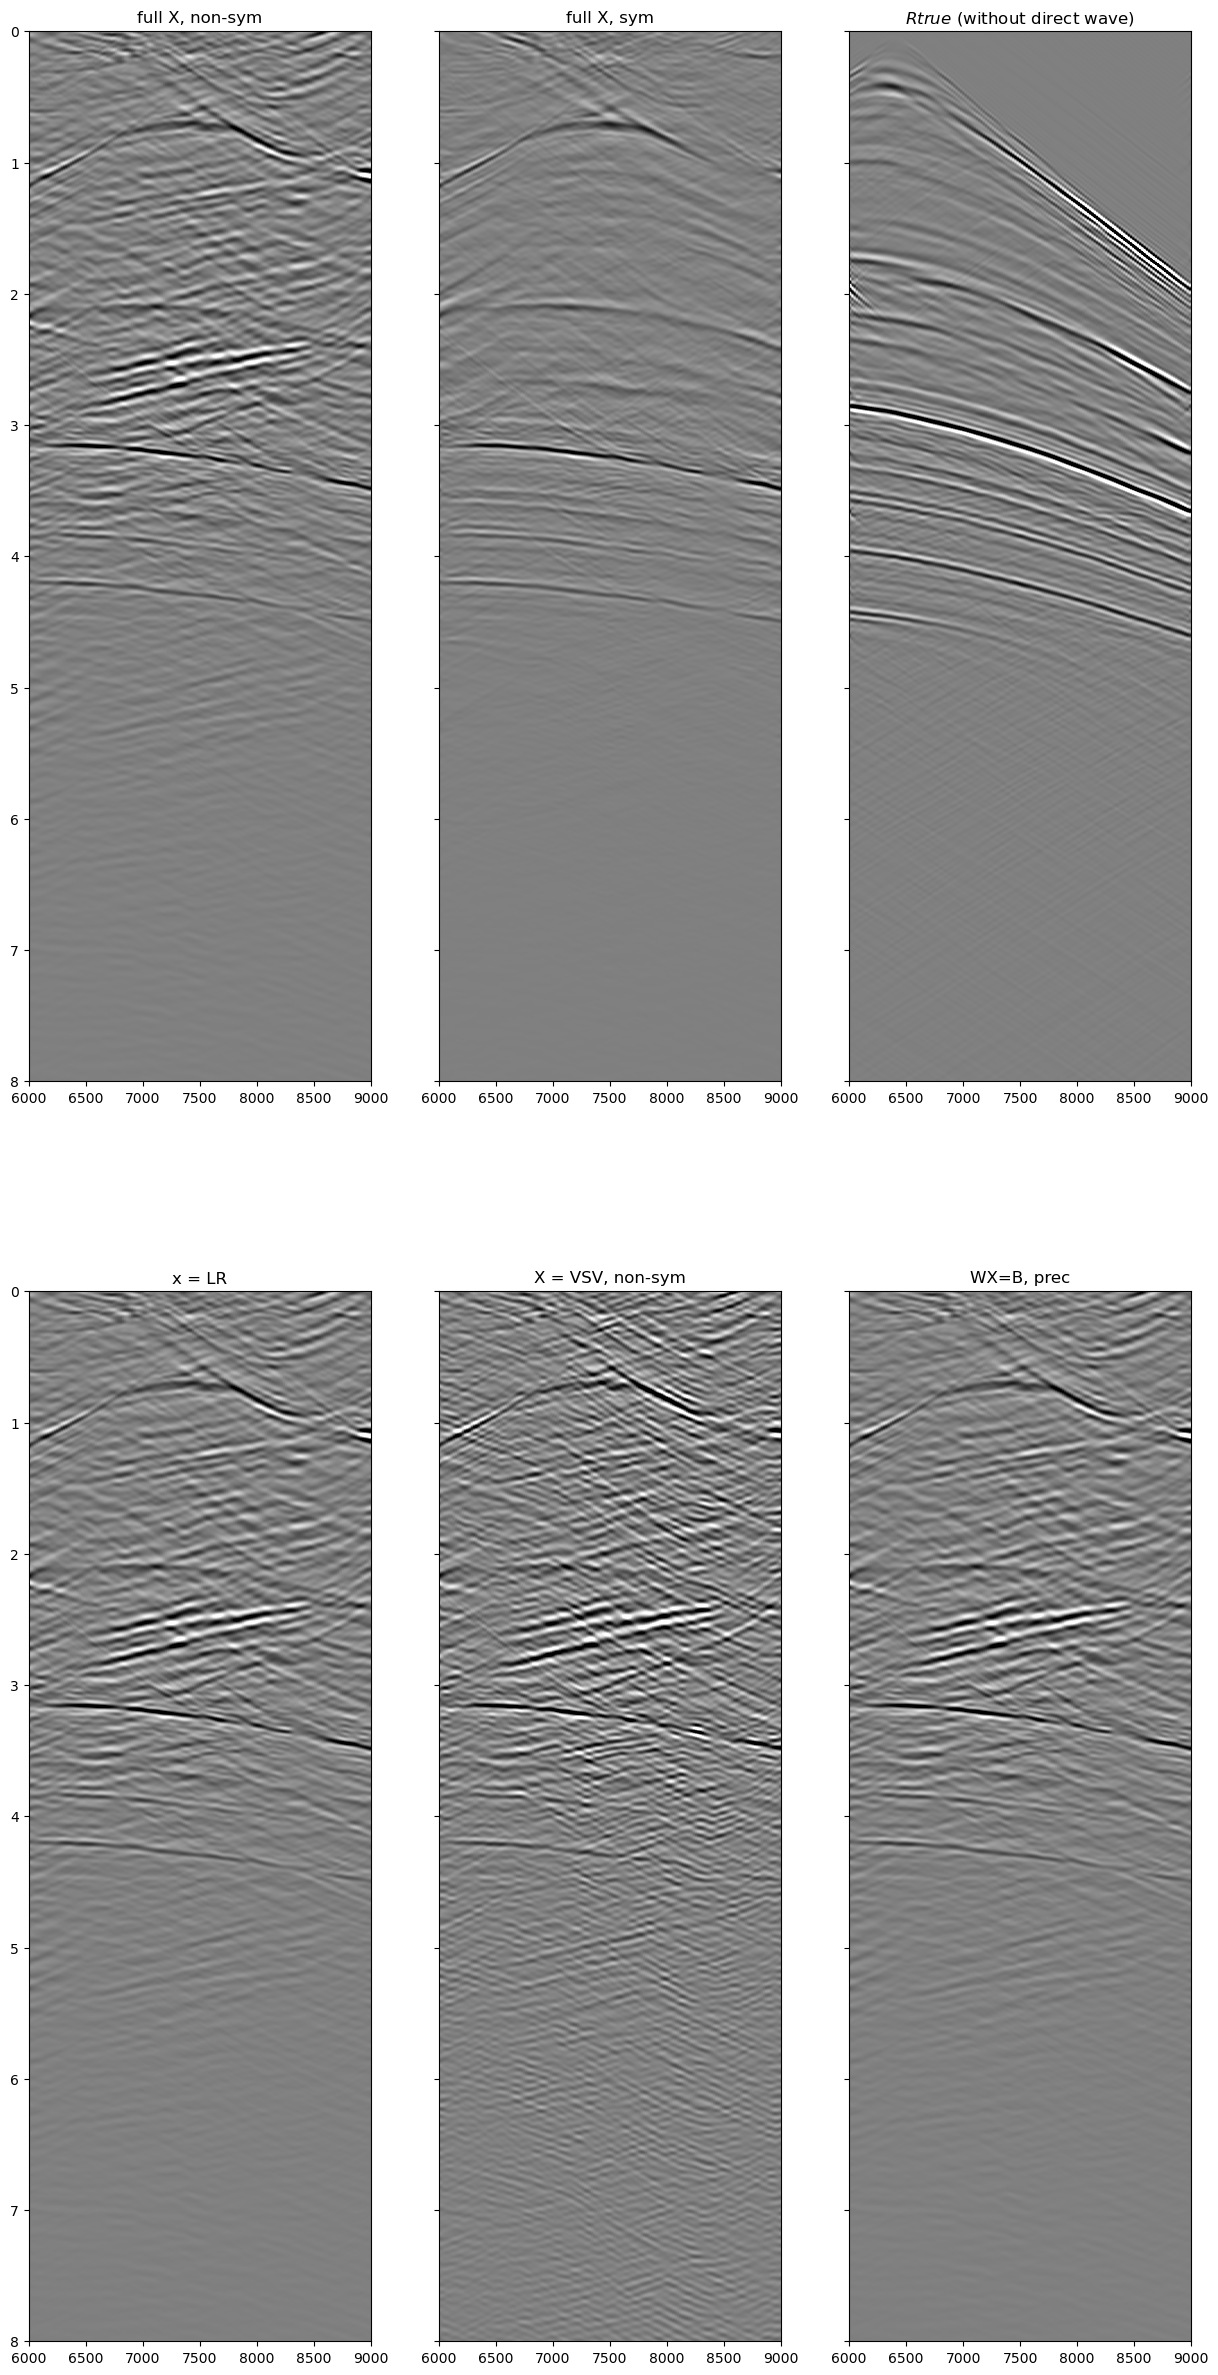

In [33]:
#plot

clip = 0.4
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(15, 30))
# fig.suptitle('R estimation (CRG)', fontweight='bold')

axs[0][0].imshow(x_full_ns_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0][0].set_title(f'full X, non-sym')
axs[0][0].axis('tight')

axs[0][1].imshow(x_full_s_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0][1].set_title(f'full X, sym')
axs[0][1].axis('tight')

axs[0][2].imshow(Rfilt[:nt//2, :, ivs], cmap='gray',
              vmin=-clip*np.abs(Rfilt[:,  nr//2]).max(), vmax=clip*np.abs(Rfilt[:,  nr//2]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0][2].set_title(f'$Rtrue$ (without direct wave)')
axs[0][2].axis('tight')
axs[0][2].set_ylim(2., 0);

axs[1][0].imshow(x_lr_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1][0].set_title(f'x = LR')
axs[1][0].axis('tight')

axs[1][1].imshow(x_vsv_ns_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1][1].set_title(f'X = VSV, non-sym')
axs[1][1].axis('tight')

axs[1][2].imshow(x_lr_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1][2].set_title(f'WX=B, prec')
axs[1][2].axis('tight')

#### sym

In [34]:
Recop =  0.5 * (Identity(nfmax * rank * rank) + \
                Transpose((nfmax, rank, rank), (0, 2, 1)))

In [35]:
UWV_Re = UWV_sm * Recop

In [36]:
t0 = time()
x_sig_s_f = lsqr(UWV_Re, sig_rhs_ten.ravel() , damp=1e-10, iter_lim=iter_lim, show=1)[0]
t_vsv_s = time() - t0
print (f'Time: {t_vsv_s} sec')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1000000 rows and 1000000 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.279e+01  3.279e+01    1.0e+00  2.3e+01
     1  3.03412e-22   2.371e+01  2.371e+01    7.2e-01  2.9e-01   1.1e+03  1.0e+00
     2  7.76416e-22   2.220e+01  2.220e+01    6.8e-01  1.2e-01   1.5e+03  2.1e+00
     3  1.43446e-21   2.170e+01  2.170e+01    6.6e-01  6.6e-02   1.7e+03  3.5e+00
     4  2.30526e-21   2.148e+01  2.148e+01    6.6e-01  4.2e-02   2.0e+03  5.0e+00
     5  3.39569e-21   2.135e+01  2.135e+01    6.5e-01  2.9e-02   2.2e+03  6.8e+00
     6  4.70153e-21   2.127e+01  2.127e+01    6.5e-01  2.2e-02   2.4e+03  8.7e+00
     7  6.23636e-21   2.121e+01  2.121e+01    6.5e-01  1.7e-02   2.6e+03  1.1e+01
     8  8.03562e-21   2.117e

In [37]:
x_sig_s_f = x_sig_s_f.reshape(nfmax, rank, rank)
x_vsv_s_f = np.zeros((nfmax, nr, nv), dtype=complex)
for ifr in range(nfmax):
    x_vsv_s_f[ifr,:,:] = BR_ten[ifr,:,:].T @ (x_sig_s_f[ifr,:,:]) @ BR_ten[ifr,:,:]
x_vsv_s_t = ((FopXf.H @ (IopXf.H @  x_vsv_s_f.ravel())).real).reshape(ntpad, nr, nv)

(6000.0, 9000.0, 8.0, 0.0)

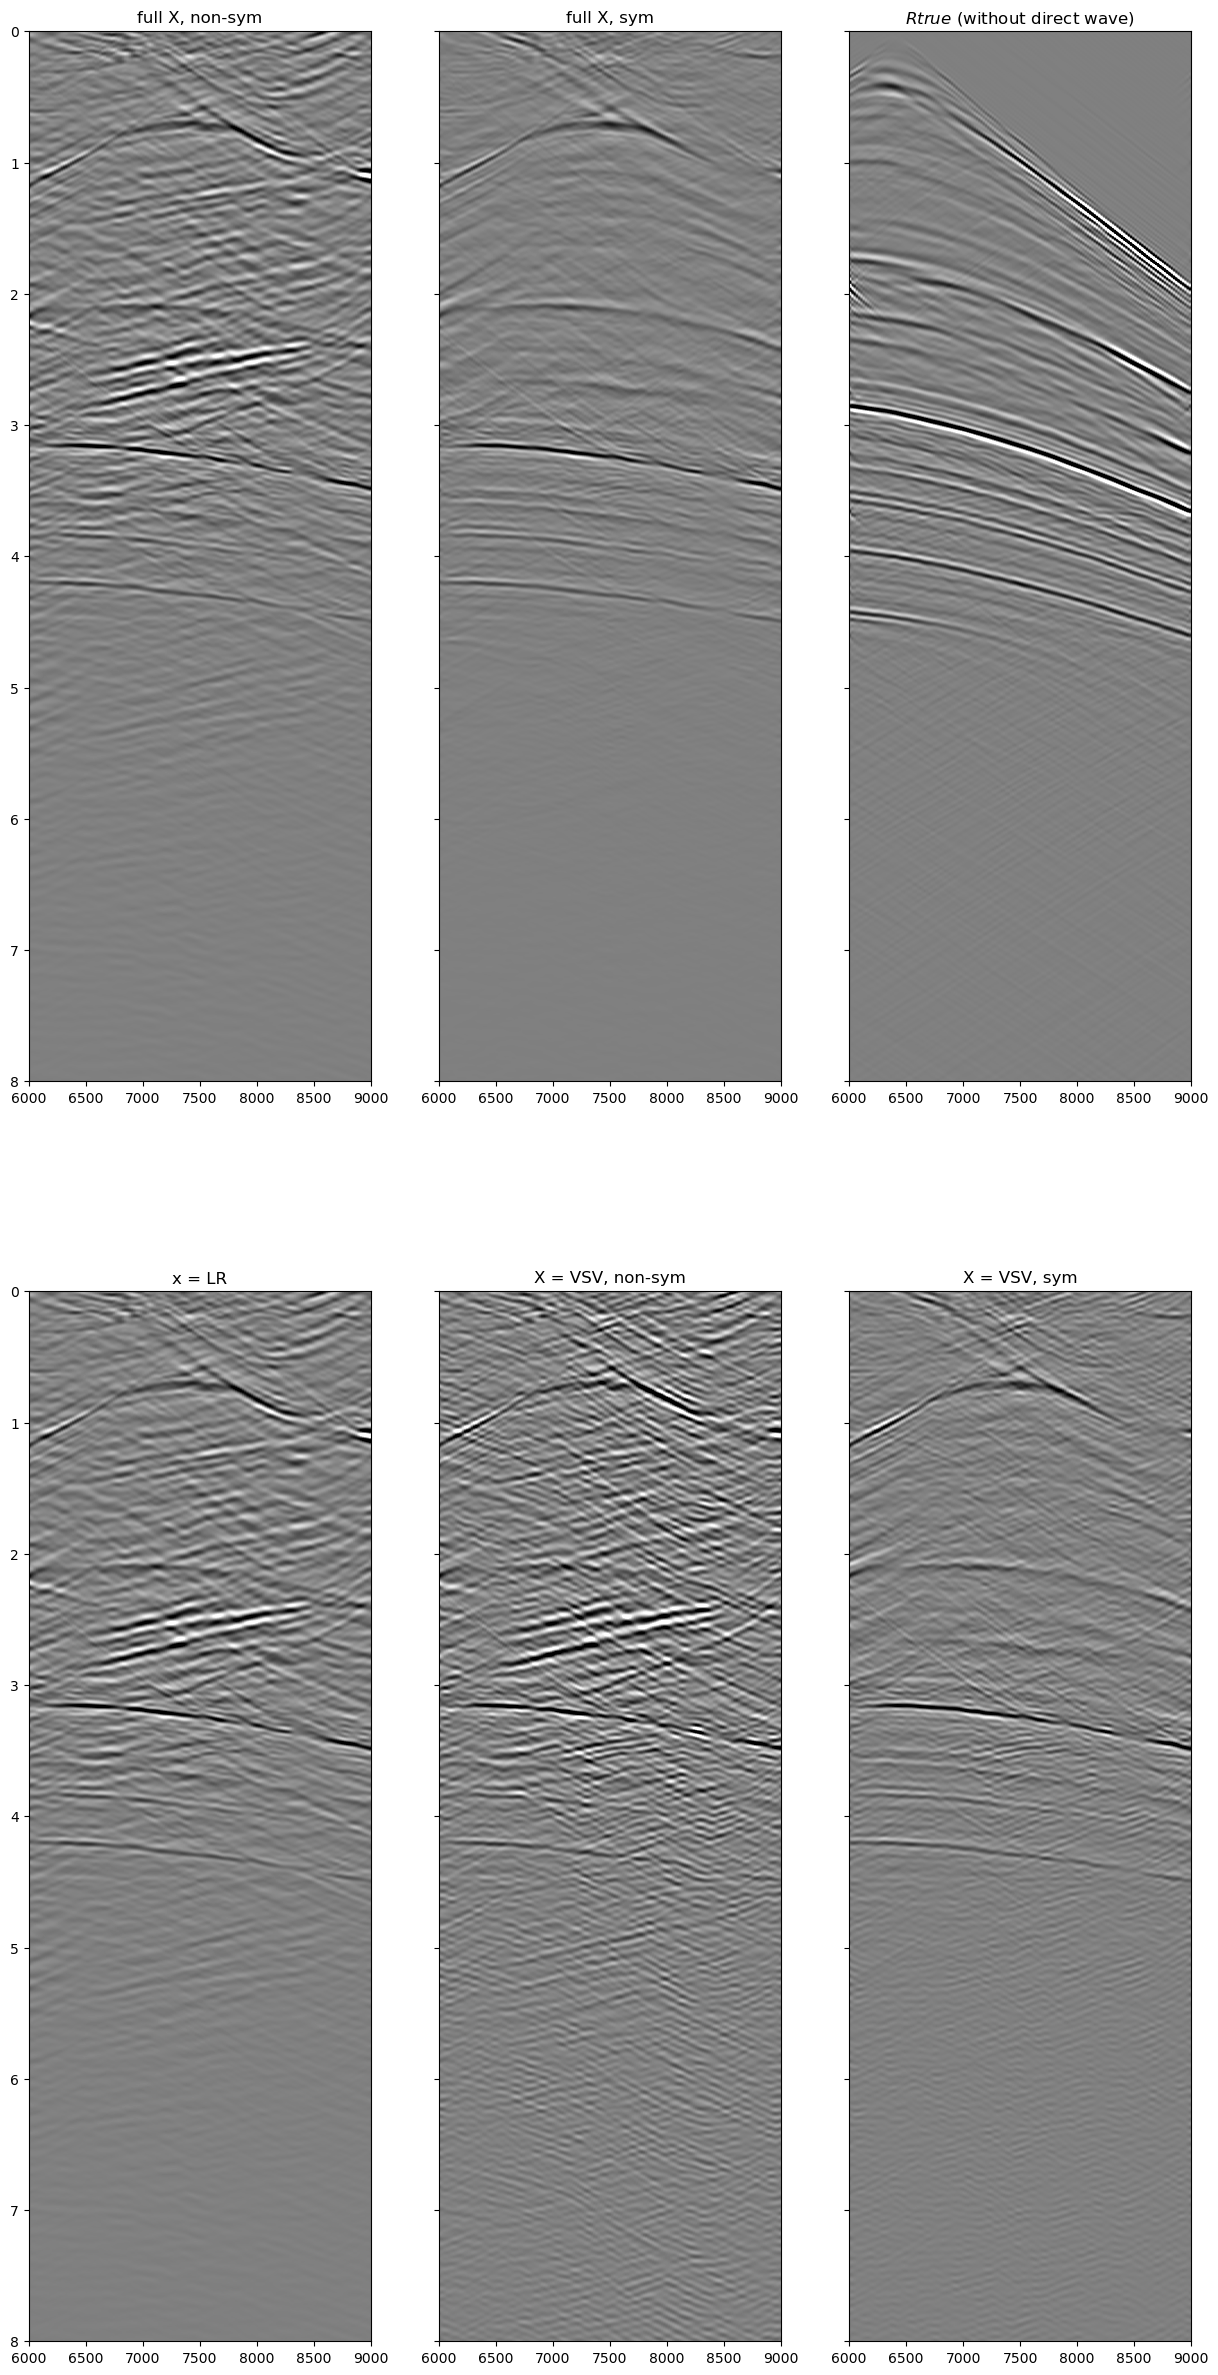

In [38]:
#plot

clip = 0.4
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(15, 30))
# fig.suptitle('R estimation (CRG)', fontweight='bold')

axs[0][0].imshow(x_full_ns_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0][0].set_title(f'full X, non-sym')
axs[0][0].axis('tight')

axs[0][1].imshow(x_full_s_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0][1].set_title(f'full X, sym')
axs[0][1].axis('tight')

axs[0][2].imshow(Rfilt[:nt//2, :, ivs], cmap='gray',
              vmin=-clip*np.abs(Rfilt[:,  nr//2]).max(), vmax=clip*np.abs(Rfilt[:,  nr//2]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0][2].set_title(f'$Rtrue$ (without direct wave)')
axs[0][2].axis('tight')
axs[0][2].set_ylim(2., 0);

axs[1][0].imshow(x_lr_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1][0].set_title(f'x = LR')
axs[1][0].axis('tight')

axs[1][1].imshow(x_vsv_ns_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1][1].set_title(f'X = VSV, non-sym')
axs[1][1].axis('tight')

axs[1][2].imshow(x_vsv_s_t[:nt//2, nr//2], cmap='gray', 
              vmin=-0.2*clip*np.abs(x_full_ns_t).max(), vmax=0.2*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1][2].set_title(f'X = VSV, sym')
axs[1][2].axis('tight')

## plots for paper

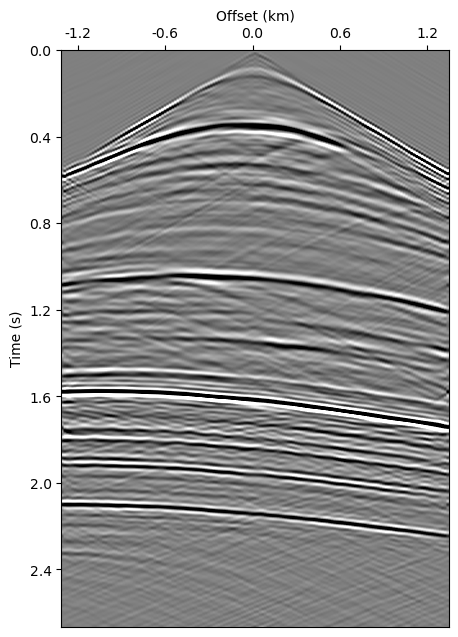

In [40]:
#analytic
from matplotlib import ticker

clip = 0.2
ivs = nr//2

x = Rfilt[:nt//2 :, ivs]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 7.5))    
ax.imshow( Rfilt[:nt//3, :, ivs], cmap='gray', vmin=-clip*np.abs(x).max(), vmax=clip*np.abs(x).max())
ax.set_ylabel('Time (s)')
ax.set_xlabel(f'Offset (km)')
ax.xaxis.set_label_position('top')

positions = np.arange(6,nr,34)
labels = np.arange(-1.2, 1.3, 0.6)
labels = [round(x,1) for x in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

positions = np.arange(0,7500,100)
labels = np.arange(0, 10, 0.4)
labels = [round(x,1) for x in labels]
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))


ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.axis('tight')

fig.savefig('../figs/ds2_analytic.png')

In [38]:
# #analytic
# from matplotlib import ticker

# clip = 0.2
# ivs = nr//2

# x = Rfilt[:nt//2, :, ivs]
# fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 7.5))    
# ax.imshow( Rfilt[:nt//2, :, ivs], cmap='gray', vmin=-clip*np.abs(x).max(), vmax=clip*np.abs(x).max())
# ax.set_ylabel('Time (s)')
# ax.set_xlabel(f'Offset (km)')
# ax.xaxis.set_label_position('top')

# positions = np.arange(6,nr,34)
# labels = np.arange(-1.2, 1.3, 0.6)
# labels = [round(x,1) for x in labels]
# ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
# ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

# positions = np.arange(0,7500,100)
# labels = np.arange(0, 10, 0.4)
# labels = [round(x,1) for x in labels]
# ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
# ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))


# ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
# ax.axis('tight')

# fig.savefig('../figs/paper/ds2_analytic.png')

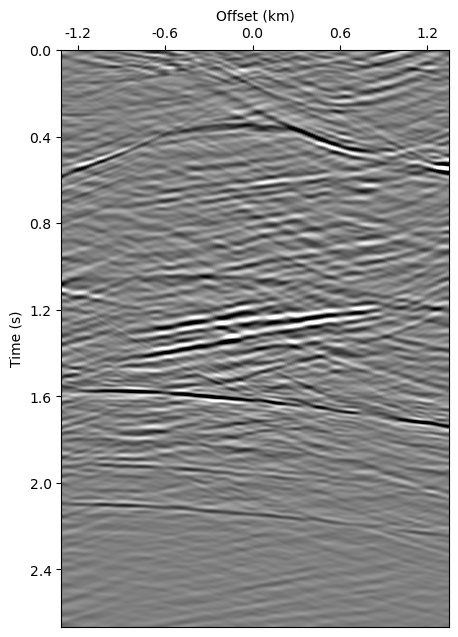

In [39]:
#full
from matplotlib import ticker

clip = 0.4
iv = 100

x = x_full_ns_t[:nt//3, nr//2]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 7.5))    
ax.imshow(x, cmap='gray', vmin=-clip*np.abs(x).max(), vmax=clip*np.abs(x).max())
ax.set_ylabel('Time (s)')
ax.set_xlabel(f'Offset (km)')
ax.xaxis.set_label_position('top')

positions = np.arange(6,nr,34)
labels = np.arange(-1.2, 1.3, 0.6)
labels = [round(x,1) for x in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

positions = np.arange(0,7500,100)
labels = np.arange(0, 10, 0.4)
labels = [round(x,1) for x in labels]
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.axis('tight')

fig.savefig('../figs/paper/ds2_full.png')

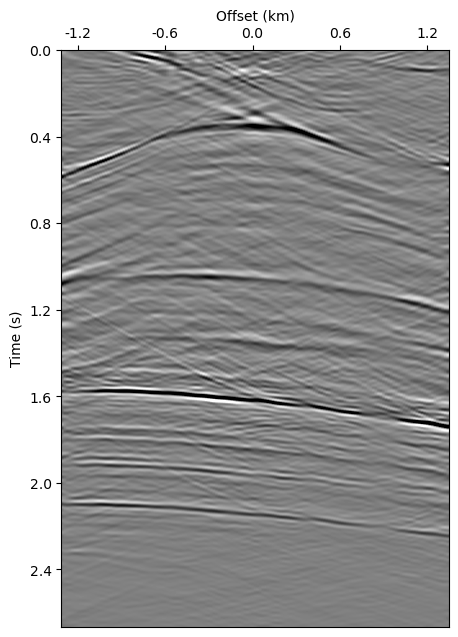

In [40]:
#full-sym
from matplotlib import ticker

clip = 0.4
iv = 100

x = x_full_s_t[:nt//3, nr//2]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 7.5))    
ax.imshow(x, cmap='gray', vmin=-clip*np.abs(x).max(), vmax=clip*np.abs(x).max())
ax.set_ylabel('Time (s)')
ax.set_xlabel(f'Offset (km)')
ax.xaxis.set_label_position('top')

positions = np.arange(6,nr,34)
labels = np.arange(-1.2, 1.3, 0.6)
labels = [round(x,1) for x in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

positions = np.arange(0,7500,100)
labels = np.arange(0, 10, 0.4)
labels = [round(x,1) for x in labels]
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.axis('tight')

fig.savefig('../figs/paper/ds2_full-sym.png')

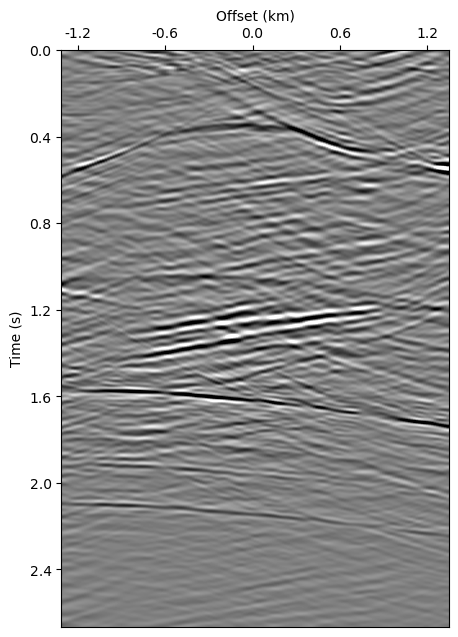

In [41]:
#lr
from matplotlib import ticker

clip = 0.4
iv = 100

x = x_lr_t[:nt//3, nr//2]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 7.5))    
ax.imshow(x, cmap='gray', vmin=-clip*np.abs(x).max(), vmax=clip*np.abs(x).max())
ax.set_ylabel('Time (s)')
ax.set_xlabel(f'Offset (km)')
ax.xaxis.set_label_position('top')

positions = np.arange(6,nr,34)
labels = np.arange(-1.2, 1.3, 0.6)
labels = [round(x,1) for x in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

positions = np.arange(0,7500,100)
labels = np.arange(0, 10, 0.4)
labels = [round(x,1) for x in labels]
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.axis('tight')

fig.savefig('../figs/paper/ds2_lr.png')

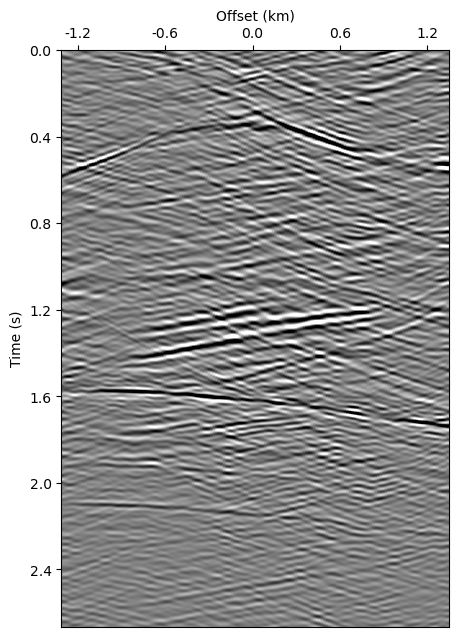

In [42]:
#usv
from matplotlib import ticker

clip = 0.4
iv = 100

x = x_vsv_ns_t[:nt//3, nr//2]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 7.5))    
ax.imshow(x, cmap='gray', vmin=-clip*np.abs(x).max(), vmax=clip*np.abs(x).max())
ax.set_ylabel('Time (s)')
ax.set_xlabel(f'Offset (km)')
ax.xaxis.set_label_position('top')

positions = np.arange(6,nr,34)
labels = np.arange(-1.2, 1.3, 0.6)
labels = [round(x,1) for x in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

positions = np.arange(0,7500,100)
labels = np.arange(0, 10, 0.4)
labels = [round(x,1) for x in labels]
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.axis('tight')

fig.savefig('../figs/paper/ds2_usv.png')

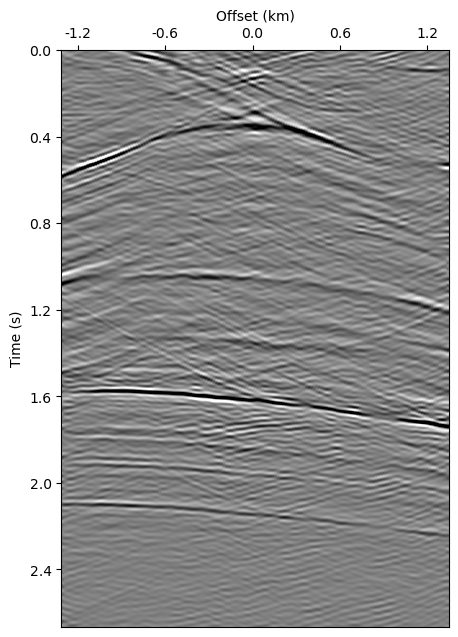

In [48]:
#usv-sym
from matplotlib import ticker

clip = 0.4
iv = 100

x = x_vsv_s_t[:nt//3, nr//2]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 7.5))    
ax.imshow(x, cmap='gray', vmin=-clip*np.abs(x).max(), vmax=clip*np.abs(x).max())
ax.set_ylabel('Time (s)')
ax.set_xlabel(f'Offset (km)')
ax.xaxis.set_label_position('top')

positions = np.arange(6,nr,34)
labels = np.arange(-1.2, 1.3, 0.6)
labels = [round(x,1) for x in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

positions = np.arange(0,7500,100)
labels = np.arange(0, 10, 0.4)
labels = [round(x,1) for x in labels]
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.axis('tight')

fig.savefig('../figs/paper/ds2_usv_sym.png')

## Make gif

In [45]:
# gif_ver = 0

In [55]:
x_vsv_ns_t.shape

(2006, 151, 151)

In [92]:
# frames between transitions
import imageio
import numpy as np 
import matplotlib.pyplot as plt 
import os

n_frames = nv
c1 = 0.2
lag = 1
clip = 0.2
cut_off_t = 1000
# x_true_t = Rfilt
sym = 1
print('Creating charts\n')
filenames = []

speed = 1

for iv in range(0, nv, speed):
# for iv in [50]:
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 10))  
    ax[0].imshow(Rfilt[:cut_off_t, :, iv], cmap='gray',
              vmin=-clip*np.abs(Rfilt[:,  nr//2]).max(), vmax=clip*np.abs(Rfilt[:,  nr//2]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
    ax[0].set_title(r'True solution')
    ax[0].axis('tight')
    ax[0].set_ylim(2., 0);
    ax[0].set_xlabel('Receivers', fontsize=10)
    ax[0].set_ylabel('Time, sec', fontsize=10)
    if sym:
        ax[1].imshow(x_full_s_t[:cut_off_t, :, iv], cmap='gray', 
              vmin=-1*c1*clip*np.abs(x_full_ns_t).max(), vmax=c1*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
        ax[1].set_title(f'Full X, {t_full_sym:.1f}s')
        ax[1].axis('tight')
        ax[1].set_xlabel('Receivers', fontsize=10)
        ax[1].set_ylabel('Time, sec', fontsize=10)
        
        ax[2].imshow(x_vsv_s_t[:cut_off_t, :, iv], cmap='gray', 
              vmin=-1*c1*clip*np.abs(x_full_ns_t).max(), vmax=1*c1*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
        ax[2].set_title(f'X = VSV, {t_vsv_s:.1f}s')
        ax[2].axis('tight')
        ax[2].set_xlabel('Receivers', fontsize=10)
        ax[2].set_ylabel('Time, sec', fontsize=10)
        
    else:
        ax[1].imshow(x_full_ns_t[:cut_off_t, :, iv], cmap='gray', 
              vmin=-1*c1*clip*np.abs(x_full_ns_t).max(), vmax=1*c1*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
        ax[1].set_title(f'Full X, {t_full_nsym:.1f}s')
        ax[1].axis('tight')
        ax[1].set_xlabel('Receivers', fontsize=10)
        ax[1].set_ylabel('Time, sec', fontsize=10)
        
        ax[2].imshow(x_vsv_ns_t[:cut_off_t, :, iv], cmap='gray', 
              vmin=-1*c1*clip*np.abs(x_full_ns_t).max(), vmax=1*c1*clip*np.abs(x_full_ns_t).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
        ax[2].set_title(f'X = VSV, {t_vsv_s:.1f}s')
        ax[2].axis('tight')
        ax[2].set_xlabel('Receivers', fontsize=10)
        ax[2].set_ylabel('Time, sec', fontsize=10)
#     fig.savefig(f'../figs/ds2_svs')
    filename = f'../figs/gifs/images/frame_{iv}.png'
    filenames.append(filename)
    for i in range(lag):
        filenames.append(filename)
    fig.savefig(filename)
    plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer(f'../figs/gifs/comp_ds2_sym{sym}_sp{speed}_v{gif_ver}.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('DONE')
gif_ver += 1

Creating charts

Charts saved

Creating gif

Gif saved

Removing Images

DONE
